# Image Captioning with RNNs
In this exercise, you will implement vanilla Recurrent Neural Networks and use them to train a model that can generate novel captions for images.

In [2]:
# Setup cell.
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.rnn_layers import *
from cs231n.captioning_solver import CaptioningSolver
from cs231n.classifiers.rnn import CaptioningRNN
from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# COCO Dataset
For this exercise, we will use the 2014 release of the [COCO dataset](https://cocodataset.org/), a standard testbed for image captioning. The dataset consists of 80,000 training images and 40,000 validation images, each annotated with 5 captions written by workers on Amazon Mechanical Turk.

**Image features.** We have preprocessed the data and extracted features for you already. For all images, we have extracted features from the fc7 layer of the VGG-16 network pretrained on ImageNet, and these features are stored in the files `train2014_vgg16_fc7.h5` and `val2014_vgg16_fc7.h5`. To cut down on processing time and memory requirements, we have reduced the dimensionality of the features from 4096 to 512 using Principal Component Analysis (PCA), and these features are stored in the files `train2014_vgg16_fc7_pca.h5` and `val2014_vgg16_fc7_pca.h5`. The raw images take up nearly 20GB of space so we have not included them in the download. Since all images are taken from Flickr, we have stored the URLs of the training and validation images in the files `train2014_urls.txt` and `val2014_urls.txt`. This allows you to download images on-the-fly for visualization.

**Captions.** Dealing with strings is inefficient, so we will work with an encoded version of the captions. Each word is assigned an integer ID, allowing us to represent a caption by a sequence of integers. The mapping between integer IDs and words is in the file `coco2014_vocab.json`, and you can use the function `decode_captions` from the file `cs231n/coco_utils.py` to convert NumPy arrays of integer IDs back into strings.

**Tokens.** There are a couple special tokens that we add to the vocabulary, and we have taken care of all implementation details around special tokens for you. We prepend a special `<START>` token and append an `<END>` token to the beginning and end of each caption respectively. Rare words are replaced with a special `<UNK>` token (for "unknown"). In addition, since we want to train with minibatches containing captions of different lengths, we pad short captions with a special `<NULL>` token after the `<END>` token and don't compute loss or gradient for `<NULL>` tokens.

You can load all of the COCO data (captions, features, URLs, and vocabulary) using the `load_coco_data` function from the file `cs231n/coco_utils.py`. Run the following cell to do so:
COCO 数据集
对于本次练习，我们将使用2014年发布的COCO数据集，这是一个标准的图像描述测试平台。该数据集包含80,000张训练图像和40,00样验图像，每张图像都由亚马逊机械土耳其工人标注了5个描述。

图像特征。我们已经预处理了数据并提取了特征。对于所有图像，我们从在ImageNet上预训练的VGG-16网络的fc7层提取了特征，这些特征存储在文件train2014_vgg16_fc7.h5和val2014_vgg16_fc7.h5中。为了减少处理时间和内存需求，我们使用主成分分析（PCA）将特征的维度从4096减少到512，这些特征存储在文件train2014_vgg16_fc7_pca.h5和val2014_vgg16_fc7_pca.h5中。原始图像占用近20GB的空间，因此我们没有将它们包含在下载中。由于所有图像都来自Flickr，我们将训练和验证图像的URL存储在文件train2014_urls.txt和val2014_urls.txt中。这允许你随时下载图像进行可视化。

描述。处理字符串效率低下，因此我们将使用编码版本的描述。每个单词被分配一个整数ID，使我们能够通过整数序列表示描述。整数ID和单词之间的映射在文件coco2014_vocab.json中，你可以使用cs231n/coco_utils.py文件中的decode_captions函数将整数ID的NumPy数组转换回字符串。

标记。我们向词汇表中添加了一对特殊标记，并为你处理了所有实现细节周围的特殊标记。我们在每个描述的开头和结尾分别预添加一个<START>标记和一个<END>标记。稀有单词被替换为一个特殊的<UNK>标记（表示“未知”）。此外，由于我们希望用包含不同长度描述的迷你批次进行训练，我们在<END>标记后用特殊的<NULL>标记填充短描述，并且不对<NULL>标记计算损失或梯度。

你可以使用cs231n/coco_utils.py文件中的load_coco_data函数加载所有的COCO数据（描述、特征、URL和词汇表）。运行以下单元格来完成此操作：


In [3]:
# Load COCO data from disk into a dictionary.
# We'll work with dimensionality-reduced features for the remainder of this assignment,
# but you can also experiment with the original features on your own by changing the flag below.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary.
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

base dir  D:\Franfi\AIstudy\Aistudy\assignment3\assignment3_cs231n_2024\cs231n\datasets/coco_captioning
train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


## Inspect the Data
It is always a good idea to look at examples from the dataset before working with it.

You can use the `sample_coco_minibatch` function from the file `cs231n/coco_utils.py` to sample minibatches of data from the data structure returned from `load_coco_data`. Run the following to sample a small minibatch of training data and show the images and their captions. Running it multiple times and looking at the results helps you to get a sense of the dataset.

http://farm1.staticflickr.com/145/405780562_48ae81fb08_z.jpg


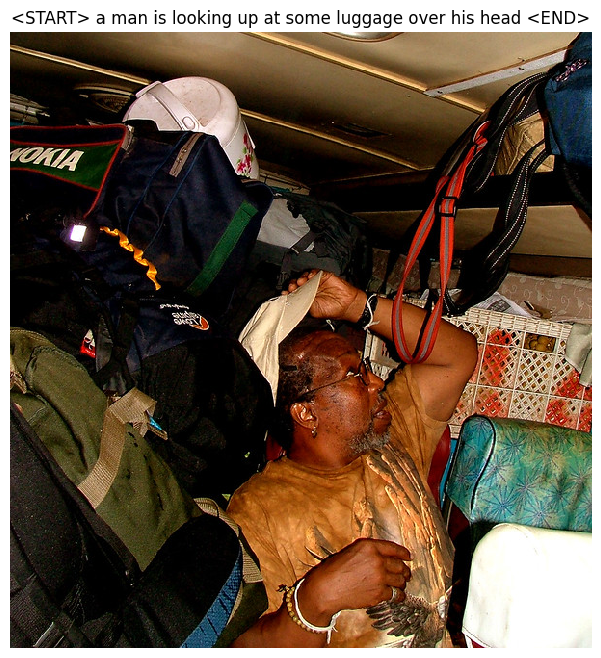

http://farm1.staticflickr.com/44/116178439_d33260d65d_z.jpg


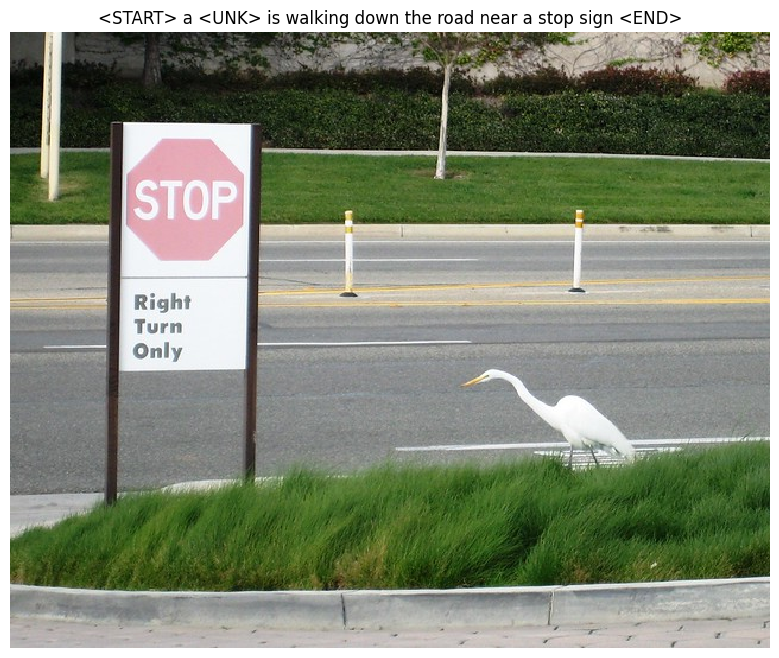

http://farm3.staticflickr.com/2311/2220257991_42c5e43581_z.jpg


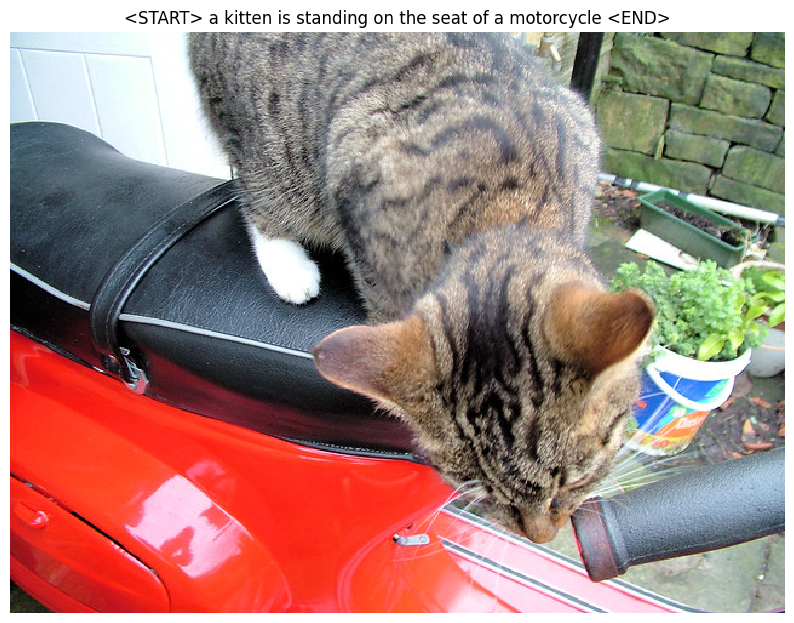

In [4]:
# Sample a minibatch and show the images and captions.
# If you get an error, the URL just no longer exists, so don't worry!
# You can re-sample as many times as you want.
batch_size = 3

captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
for i, (caption, url) in enumerate(zip(captions, urls)):
    print(url)
    plt.imshow(image_from_url(url))
    plt.axis('off')
    caption_str = decode_captions(caption, data['idx_to_word'])
    plt.title(caption_str)
    plt.show()

# Recurrent Neural Network
As discussed in lecture, we will use Recurrent Neural Network (RNN) language models for image captioning. The file `cs231n/rnn_layers.py` contains implementations of different layer types that are needed for recurrent neural networks, and the file `cs231n/classifiers/rnn.py` uses these layers to implement an image captioning model.

We will first implement different types of RNN layers in `cs231n/rnn_layers.py`.

**NOTE:** The Long-Short Term Memory (LSTM) RNN is a common variant of the vanilla RNN. `LSTM_Captioning.ipynb` is optional extra credit, so don't worry about references to LSTM in `cs231n/classifiers/rnn.py` and `cs231n/rnn_layers.py` for now.
循环神经网络
如讲座中所讨论的，我们将使用循环神经网络（RNN）语言模型进行图像标注。文件 cs231n/rnn_layers.py 包含了循环神经网络所需的不同层次类型的实现，而文件 cs231n/classifiers/rnn.py 使用这些层次来实现图像标注模型。
我们首先将在 cs231n/rnn_layers.py 中实现不同类型的 RNN 层。
注意： 长短期记忆（LSTM）RNN 是普通变体 RNN 的一种常见变体。LSTM_Captioning.ipynb 是可选的额外学分，所以现在不用担心在 cs231n/classifiers/rnn.py 和 cs231n/rnn_layers.py 中提到的 LSTM。

# Vanilla RNN: Step Forward
Open the file `cs231n/rnn_layers.py`. This file implements the forward and backward passes for different types of layers that are commonly used in recurrent neural networks.

First implement the function `rnn_step_forward` which implements the forward pass for a single timestep of a vanilla recurrent neural network. After doing so run the following to check your implementation. You should see errors on the order of e-8 or less.
香草RNN：前向传播
打开文件cs231n/rnn_layers.py。这个文件实现了在循环神经网络中常用的不同类型层的前向和反向传播。
首先实现函数rnn_step_forward，它实现了香草循环神经网络单个时间步的前向传播。完成后，运行以下代码来检查你的实现。你应该看到错误在e-8或更小的数量级。


In [9]:
N, D, H = 3, 10, 4

x = np.linspace(-0.4, 0.7, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.2, 0.5, num=N*H).reshape(N, H)
Wx = np.linspace(-0.1, 0.9, num=D*H).reshape(D, H)
Wh = np.linspace(-0.3, 0.7, num=H*H).reshape(H, H)
b = np.linspace(-0.2, 0.4, num=H)

next_h, _ = rnn_step_forward(x, prev_h, Wx, Wh, b)
expected_next_h = np.asarray([
  [-0.58172089, -0.50182032, -0.41232771, -0.31410098],
  [ 0.66854692,  0.79562378,  0.87755553,  0.92795967],
  [ 0.97934501,  0.99144213,  0.99646691,  0.99854353]])

print('next_h error: ', rel_error(expected_next_h, next_h))

next_h error:  6.292421426471037e-09


# Vanilla RNN: Step Backward
In the file `cs231n/rnn_layers.py` implement the `rnn_step_backward` function. After doing so run the following to numerically gradient check your implementation. You should see errors on the order of `e-8` or less.

In [14]:
from cs231n.rnn_layers import rnn_step_forward, rnn_step_backward
np.random.seed(231)
N, D, H = 4, 5, 6
x = np.random.randn(N, D)
h = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_step_forward(x, h, Wx, Wh, b)

dnext_h = np.random.randn(*out.shape)

fx = lambda x: rnn_step_forward(x, h, Wx, Wh, b)[0]
fh = lambda prev_h: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_step_forward(x, h, Wx, Wh, b)[0]
fb = lambda b: rnn_step_forward(x, h, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dnext_h)
dprev_h_num = eval_numerical_gradient_array(fh, h, dnext_h)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dnext_h)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dnext_h)
db_num = eval_numerical_gradient_array(fb, b, dnext_h)

dx, dprev_h, dWx, dWh, db = rnn_step_backward(dnext_h, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dprev_h error: ', rel_error(dprev_h_num, dprev_h))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  2.297563843704853e-10
dprev_h error:  2.363646400864272e-10
dWx error:  7.093603372542699e-10
dWh error:  9.042329430116797e-10
db error:  3.6230341996569033e-11


# Vanilla RNN: Forward
Now that you have implemented the forward and backward passes for a single timestep of a vanilla RNN, you will combine these pieces to implement a RNN that processes an entire sequence of data.

In the file `cs231n/rnn_layers.py`, implement the function `rnn_forward`. This should be implemented using the `rnn_step_forward` function that you defined above. After doing so run the following to check your implementation. You should see errors on the order of `e-7` or less.


In [27]:
N, T, D, H = 2, 3, 4, 5

x = np.linspace(-0.1, 0.3, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.3, 0.1, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.4, num=D*H).reshape(D, H)
Wh = np.linspace(-0.4, 0.1, num=H*H).reshape(H, H)
b = np.linspace(-0.7, 0.1, num=H)

h, _ = rnn_forward(x, h0, Wx, Wh, b)
expected_h = np.asarray([
  [
    [-0.42070749, -0.27279261, -0.11074945,  0.05740409,  0.22236251],
    [-0.39525808, -0.22554661, -0.0409454,   0.14649412,  0.32397316],
    [-0.42305111, -0.24223728, -0.04287027,  0.15997045,  0.35014525],
  ],
  [
    [-0.55857474, -0.39065825, -0.19198182,  0.02378408,  0.23735671],
    [-0.27150199, -0.07088804,  0.13562939,  0.33099728,  0.50158768],
    [-0.51014825, -0.30524429, -0.06755202,  0.17806392,  0.40333043]]])
print('h error: ', rel_error(expected_h, h))

h error:  7.728466092662457e-08


# Vanilla RNN: Backward
In the file `cs231n/rnn_layers.py`, implement the backward pass for a vanilla RNN in the function `rnn_backward`. This should run back-propagation over the entire sequence, making calls to the `rnn_step_backward` function that you defined earlier. You should see errors on the order of `e-6` or less.

In [43]:
np.random.seed(231)

N, D, T, H = 2, 3, 10, 5

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)
dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

fx = lambda x: rnn_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: rnn_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: rnn_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  1.5403852724205583e-09
dh0 error:  3.383382150949403e-09
dWx error:  7.281540210697682e-09
dWh error:  1.319826490216877e-07
db error:  1.445481695076255e-10
